![Python Programming for Scientists in a hurry](fig/Title_Python.png)

<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 60%; padding: 5px">
  <h1 id="subtitle">Chapter 8. Cython</h1>
  <h2 id="subtitle">Guillermo Avendaño Franco<br>Aldo Humberto Romero</h2>
  <br>
  <img src="fig/1-line logotype124-295.png" alt="Scientific Computing with Python" style="width:50%" align="left">
  </div>
  <div style="border: none; float: left; width: 30%; padding: 5px">
  <img src="fig/SCPython.png" alt="Scientific Computing with Python" style="width:100%">
  </div>
</div>

## List of Notebooks

Python is a great general-purpose programming language on its own. 
Python is a general purpose programming language. It is interpreted and dynamically typed and is very suited for interactive work and quick prototyping while being powerful enough to write large applications in.
The lesson is particularly oriented to Scientific Computing. 
Other episodes in the series include:

  * Language Syntax
  * Standard Library
  * Scientific Packages
  * NumPy
  * Matplotlib
  * SciPy 
  * Pandas
  * **Cython \[This notebook\]**
  * Parallel Computing

After completing all the series in this lesson you will realize that python has become a powerful environment for scientific computing at several levels, from interactive computing to scripting to big project developments.

## Setup

In [1]:
%load_ext watermark

In [2]:
%watermark

Last updated: 2022-08-22T22:14:13.186632-04:00

Python implementation: CPython
Python version       : 3.10.5
IPython version      : 8.4.0

Compiler    : GCC 11.2.0
OS          : Linux
Release     : 3.10.0-1160.24.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 52
Architecture: 64bit



In [3]:
import time
start = time.time()
chapter_number = 8
import matplotlib
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import cython
import matplotlib.pyplot as plt

In [5]:
%watermark -iv

cython    : 0.29.32
matplotlib: 3.5.3
numpy     : 1.22.4



# Cython: Accelerate Python Execution

Cython is a language that extends Python. With minimal changes to a python code, you can get a compiled code that runs faster. From another perspective, Cython is like a bridge that allows you to interface C and C++ routines inside python.

We will follow a very practical route to give you basic elements that will quickly improve the performance of your code with minimal effort. In scientific computing, performance is central, but also you want to optimize the time spent developing the code. The right balance between both is the goal. Using Python is an efficient way of getting a code that works, but still, work must be done to make it efficient.

Using Jupyter notebooks is easy to "cythonize" python code.  For this, you need to load the Cython magic:

In [6]:
%load_ext cython

## Original Python Code: Sieve of Eratosthenes

Let us consider a classical algorithm, the Sieve of Eratosthenes. Eratosthenes is best known for being the first person to calculate the circumference of the Earth. He is also known for inventing a clever method of identifying prime numbers. This algorithm is more than 2000 years old and it is still a reasonable first approach to find all the primes up to a given limit.

The algorithm consists in marking all the numbers as prime candidates, starting from 2 you remove the mark for all multiples of 2. The next after 2 is 3 and still marked, so it is prime and we unmark all its multiples, the next number 4 is already unmarked, so we move to the next one, 5, and unmark all its multiples. Doing that over and over we end up unmarking all the non-primes and leaving primes numbers marked.

Below is a python code implemented with pure python variables (integers and lists). 
The code happens to be very poor in performance as we are using an interpreted language and lists and loops. 
These elements make the code run very slowly. This implementation was done on purpose because it allows us to explore how to improve it from there.

In [7]:
def SieveOfEratosthenes_orig(n):

    if n%2 == 0:
        imax=int(n/2)
    else:
        imax=int((n+1)/2)

    neff= 2*(imax-1)+1
    prime = imax*[True]

    print(" Dimension of array: %d\n" % imax)
    print(" Array with indices between 0 to %d\n" % (imax-1))
    print(" Stores primality of odd numbers in range [1, %d]\n\n" % neff)

    # The loop runs over all odd numbers starting at 3
    p=3
    while (p<n/2+1):
        # If prime[p] is true, then it is a prime
        if(prime[int((p-1)/2)] is True):
            # Update all multiples of p
            i = 2*p
            while (i <= neff):
                if (i%2!=0):
                    prime[int((i-1)/2)] = False
                i += p
        p+=2

    counter = 1
    nprimes = 0
    # Print all prime numbers if the number is small otherwise just count the number of primes found
    if (imax < 10000):
        print("%10d " % 2, end='')
        # Starting with index 1 instead of zero because (2*0)+1 = 1 is not prime
        for i in range(1,imax):
            if(prime[i] == 1):
                print("%10d " % (2*i+1), end='')
                counter+=1

            if (counter == 15):
                print("")
                counter=0

        print("\n")

    else:
        for i in range(1,imax):
            if(prime[i] is True):
                nprimes+=1
        print(" Total number of primes found: %d" % nprimes)

    return nprimes

### Timing the execution

With IPython we can use the timing function from the `%timeit` magic, the code is executed several times and the best time is reported

In [8]:
t1=%timeit -o SieveOfEratosthenes_orig(50E6)

 Dimension of array: 25000000

 Array with indices between 0 to 24999999

 Stores primality of odd numbers in range [1, 49999999]


 Total number of primes found: 3001133
 Dimension of array: 25000000

 Array with indices between 0 to 24999999

 Stores primality of odd numbers in range [1, 49999999]


 Total number of primes found: 3001133
 Dimension of array: 25000000

 Array with indices between 0 to 24999999

 Stores primality of odd numbers in range [1, 49999999]


 Total number of primes found: 3001133
 Dimension of array: 25000000

 Array with indices between 0 to 24999999

 Stores primality of odd numbers in range [1, 49999999]


 Total number of primes found: 3001133
 Dimension of array: 25000000

 Array with indices between 0 to 24999999

 Stores primality of odd numbers in range [1, 49999999]


 Total number of primes found: 3001133
 Dimension of array: 25000000

 Array with indices between 0 to 24999999

 Stores primality of odd numbers in range [1, 49999999]


 Total number

## Using Cython with pristine code

Our first movement will be to run the code unmodified, the only change is the first line in the Jupiter box indicating that we want the code to be compiled with Cython

In [9]:
%%cython -3 -a
def SieveOfEratosthenes_cython_plain(n):

    if n%2 == 0:
        imax=int(n/2)
    else:
        imax=int((n+1)/2)

    neff= 2*(imax-1)+1
    prime = imax*[True]

    print(" Dimension of array: %d\n" % imax)
    print(" Array with indices between 0 to %d\n" % (imax-1))
    print(" Stores primality of odd numbers in range [1, %d]\n\n" % neff)

    # The loop runs over all odd numbers starting at 3
    p=3
    while (p<n/2+1):
        # If prime[p] is true, then it is a prime
        if(prime[int((p-1)/2)] is True):
            # Update all multiples of p
            i = 2*p
            while (i <= neff):
                if (i%2!=0):
                    prime[int((i-1)/2)] = False
                i += p
        p+=2

    counter = 1
    nprimes = 0
    # Print all prime numbers if the number is small otherwise just count the number of primes found
    if (imax < 10000):
        print("%10d " % 2, end='')
        # Starting with index 1 instead of zero because (2*0)+1 = 1 is not prime
        for i in range(1,imax):
            if(prime[i] == 1):
                print("%10d " % (2*i+1), end='')
                counter+=1

            if (counter == 15):
                print("")
                counter=0

        print("\n")

    else:
        for i in range(1,imax):
            if(prime[i] is True):
                nprimes+=1
        print(" Total number of primes found: %d" % nprimes)

    return nprimes

With `%%cython -3 -a` the code is cythonized, ie converted into C code that is afterward compiled and converted into a Python module. The argument `-3` is to indicate that we are using Python 3.x and `-a` to annotate the code, as shown above, white lines are regions of Python code that could be converted into pure C code. The lines are colored more and more yellow as the code on them could be less and less translated into C code. Bright yellow meaning that those lines could not be translated and will remain as Python code.

### Timing the execution

In [10]:
t2=%timeit -o SieveOfEratosthenes_cython_plain(50E6)

 Dimension of array: 25000000

 Array with indices between 0 to 24999999

 Stores primality of odd numbers in range [1, 49999999]


 Total number of primes found: 3001133
 Dimension of array: 25000000

 Array with indices between 0 to 24999999

 Stores primality of odd numbers in range [1, 49999999]


 Total number of primes found: 3001133
 Dimension of array: 25000000

 Array with indices between 0 to 24999999

 Stores primality of odd numbers in range [1, 49999999]


 Total number of primes found: 3001133
 Dimension of array: 25000000

 Array with indices between 0 to 24999999

 Stores primality of odd numbers in range [1, 49999999]


 Total number of primes found: 3001133
 Dimension of array: 25000000

 Array with indices between 0 to 24999999

 Stores primality of odd numbers in range [1, 49999999]


 Total number of primes found: 3001133
 Dimension of array: 25000000

 Array with indices between 0 to 24999999

 Stores primality of odd numbers in range [1, 49999999]


 Total number

## Static typing

Python is a dynamic language, meaning that you can declare variables just by initializing them with values, and you can change values for the same variable, for example declaring a variable to be a number and later on changing the variable to be a string.

This can make Python a very relaxed and comfortable language for rapid development, but that flexibility comes with a price. The Python interpreter has to do extra work to figure out which kind of variable you have associated with a given variable when you execute an operation with it. The interpreter has to search namespaces, fetch attributes and parse argument and keyword tuples. 
This is a big reason why Python is considered slow when compared with other languages like C or Fortran.

However with Cython, it is possible to gain significant speed-ups through the use of ‘early binding’ programming techniques.

As you saw above, declaring the type of variable is not a necessity. Cython can give you some performance just from the code as it was originally. 

Providing static typing to parameters and variables is convenient to speed up your code, this is our next step. 

You should optimize where and when needed. Not doing it right and you can slow down your code in the case where the typing does not allow optimizations but where Cython still needs to check that the type of some object matches the declared type.

In our case, the decision is quite simple. All the variables `imax, neff, p, i, counter` and `nprimes` are integers and will be integers during the entire execution. We can declare that with the line

    cdef int imax, neff, p, i, counter, nprimes
    
That is our next step the code is the same except for that single line

In [11]:
%%cython -3 -a
def SieveOfEratosthenes_cython_static(n):

    # Type declared variables for cython
    cdef int imax, neff, p, i, counter, nprimes
    
    if n%2 == 0:
        imax=int(n/2)
    else:
        imax=int((n+1)/2)

    neff= 2*(imax-1)+1
    prime = imax*[True]

    print(" Dimension of array: %d\n" % imax)
    print(" Array with indices between 0 to %d\n" % (imax-1))
    print(" Stores primality of odd numbers in range [1, %d]\n\n" % neff)

    # The loop runs over all odd numbers starting at 3
    p=3
    while (p<n/2+1):
        # If prime[p] is true, then it is a prime
        if(prime[int((p-1)/2)] is True):
            # Update all multiples of p
            i = 2*p
            while (i <= neff):
                if (i%2!=0):
                    prime[int((i-1)/2)] = False
                i += p
        p+=2

    counter = 1
    nprimes = 0
    # Print all prime numbers if the number is small otherwise just count the number of primes found
    if (imax < 10000):
        print("%10d " % 2, end='')
        # Starting with index 1 instead of zero because (2*0)+1 = 1 is not prime
        for i in range(1,imax):
            if(prime[i] == 1):
                print("%10d " % (2*i+1), end='')
                counter+=1

            if (counter == 15):
                print("")
                counter=0

        print("\n")

    else:
        for i in range(1,imax):
            if(prime[i] is True):
                nprimes+=1
        print(" Total number of primes found: %d" % nprimes)

    return nprimes

### Timing the execution

In [12]:
t3=%timeit -o SieveOfEratosthenes_cython_static(50E6)

 Dimension of array: 25000000

 Array with indices between 0 to 24999999

 Stores primality of odd numbers in range [1, 49999999]


 Total number of primes found: 3001133
 Dimension of array: 25000000

 Array with indices between 0 to 24999999

 Stores primality of odd numbers in range [1, 49999999]


 Total number of primes found: 3001133
 Dimension of array: 25000000

 Array with indices between 0 to 24999999

 Stores primality of odd numbers in range [1, 49999999]


 Total number of primes found: 3001133
 Dimension of array: 25000000

 Array with indices between 0 to 24999999

 Stores primality of odd numbers in range [1, 49999999]


 Total number of primes found: 3001133
 Dimension of array: 25000000

 Array with indices between 0 to 24999999

 Stores primality of odd numbers in range [1, 49999999]


 Total number of primes found: 3001133
 Dimension of array: 25000000

 Array with indices between 0 to 24999999

 Stores primality of odd numbers in range [1, 49999999]


 Total number

## Working with C arrays and pointers

One of the reasons why the Python code that we proposed initially runs so slow is that we are storing the primality condition for all odd numbers as a big list. Python lists are very flexible, they are mutable, meaning that you can add and remove elements to the list and change the values on the fly. Those features are nice but also come with a performance tag. This time we need to introduce more changes.

Instead of a list, we will declare `prime` to be a pointer, basically an array of integer numbers. 
We know that we want `imax` integers to allocate. The following line will create the array.

    cdef int *prime = <int *> malloc(imax * sizeof(int))

In [13]:
%%cython -3 -a
from libc.stdio cimport printf
from libc.stdlib cimport malloc, free

def SieveOfEratosthenes_cython_carray(n):

    cdef int imax, neff, p, i, counter, nprimes

    if n%2 == 0:
        imax=int(n/2)
    else:
        imax=int((n+1)/2)

    neff= 2*(imax-1)+1

    cdef int *prime = <int *> malloc(imax * sizeof(int))
    for i in range(imax):
        prime[i]=1    

    print(" Dimension of array: %d\n" % imax)
    print(" Array with indices between 0 to %d\n" % (imax-1))
    print(" Stores primality of odd numbers in range [1, %d]\n\n" % neff)

    # The loop runs over all odd numbers starting at 3
    p=3
    while (p<n/2+1):
        # If prime[p] is true, then it is a prime
        if(prime[int((p-1)/2)] == 1):
            # Update all multiples of p
            i = 2*p
            while (i <= neff):
                if (i%2!=0):
                    prime[int((i-1)/2)] = 0
                i += p
        p+=2

    counter = 1
    nprimes = 0
    # Print all prime numbers if the number is small otherwise just count the number of primes found
    if (imax < 10000):
        print("%10d " % 2, end='')
        # Starting with index 1 instead of zero because (2*0)+1 = 1 is not prime
        for i in range(1,imax):
            if(prime[i] == 1):
                print("%10d " % (2*i+1), end='')
                counter+=1

            if (counter == 15):
                print("")
                counter=0

        print("\n")

    else:
        for i in range(1,imax):
            if(prime[i] == 1):
                nprimes+=1
        print(" Total number of primes found: %d" % nprimes)

    free(prime)
    return nprimes

### Timing the execution

In [14]:
t4=%timeit -o SieveOfEratosthenes_cython_carray(50E6)

 Dimension of array: 25000000

 Array with indices between 0 to 24999999

 Stores primality of odd numbers in range [1, 49999999]


 Total number of primes found: 3001133
 Dimension of array: 25000000

 Array with indices between 0 to 24999999

 Stores primality of odd numbers in range [1, 49999999]


 Total number of primes found: 3001133
 Dimension of array: 25000000

 Array with indices between 0 to 24999999

 Stores primality of odd numbers in range [1, 49999999]


 Total number of primes found: 3001133
 Dimension of array: 25000000

 Array with indices between 0 to 24999999

 Stores primality of odd numbers in range [1, 49999999]


 Total number of primes found: 3001133
 Dimension of array: 25000000

 Array with indices between 0 to 24999999

 Stores primality of odd numbers in range [1, 49999999]


 Total number of primes found: 3001133
 Dimension of array: 25000000

 Array with indices between 0 to 24999999

 Stores primality of odd numbers in range [1, 49999999]


 Total number

## Python functions from Cython

Up to now, we have gained a lot of performance with just 2 extra lines of code. Most of the annotated code is mostly white, but there are still a few yellow lines. The argument to the function `n` has not been typed, so all references to it cannot be fully converted into C code. As that is the argument of the function we have to work into C functions.

There are two kinds of function definition in Cython: Python functions and C functions.
Python functions are defined using the `def` statement, the usual statement in Python. 
They take Python objects as parameters and return Python objects.

C functions are defined using the new `cdef` statement. 
They take either Python objects or C values as parameters, and can return either Python objects or C values.

Within a Cython module, Python functions and C functions can call each other freely, but only Python functions can be called from outside the module by interpreted Python code. So, any functions that you want to “export” from your Cython module must be declared as Python functions using `def`. There is also a hybrid function, called `cpdef`. A `cpdef` can be called from anywhere but uses the faster C calling conventions when being called from other Cython code. A `cpdef` can also be overridden by a Python method on a subclass or an instance attribute, even when called from Cython. If this happens, most performance gains are of course lost and even if it does not, there is a tiny overhead in calling a `cpdef` method from Cython compared to calling a `cdef` method.

Our next step is replacing the function from Python definition to the hybrid `cpdef` definition

    cpdef int SieveOfEratosthenes_cython_cfunc(int n):

In [15]:
%%cython -3 -a
from libc.stdio cimport printf
from libc.stdlib cimport malloc, free

cpdef int SieveOfEratosthenes_cython_cfunc(int n):

    cdef int imax, neff, p, i, counter, nprimes

    if n%2 == 0:
        imax=int(n/2)
    else:
        imax=int((n+1)/2)

    neff= 2*(imax-1)+1

    cdef int *prime = <int *> malloc(imax * sizeof(int))
    for i in range(imax):
        prime[i]=1    

    print(" Dimension of array: %d\n" % imax)
    print(" Array with indices between 0 to %d\n" % (imax-1))
    print(" Stores primality of odd numbers in range [1, %d]\n\n" % neff)

    # The loop runs over all odd numbers starting at 3
    p=3
    while (p<n/2+1):
        # If prime[p] is true, then it is a prime
        if(prime[int((p-1)/2)] == 1):
            # Update all multiples of p
            i = 2*p
            while (i <= neff):
                if (i%2!=0):
                    prime[int((i-1)/2)] = 0
                i += p
        p+=2

    counter = 1
    nprimes = 0
    # Print all prime numbers if the number is small otherwise just count the number of primes found
    if (imax < 10000):
        print("%10d " % 2, end='')
        # Starting with index 1 instead of zero because (2*0)+1 = 1 is not prime
        for i in range(1,imax):
            if(prime[i] == 1):
                print("%10d " % (2*i+1), end='')
                counter+=1

            if (counter == 15):
                print("")
                counter=0

        print("\n")

    else:
        for i in range(1,imax):
            if(prime[i] == 1):
                nprimes+=1
        print(" Total number of primes found: %d" % nprimes)

    free(prime)
    return nprimes

### Timing the execution

In [16]:
t5=%timeit -o SieveOfEratosthenes_cython_cfunc(50000000)

 Dimension of array: 25000000

 Array with indices between 0 to 24999999

 Stores primality of odd numbers in range [1, 49999999]


 Total number of primes found: 3001133
 Dimension of array: 25000000

 Array with indices between 0 to 24999999

 Stores primality of odd numbers in range [1, 49999999]


 Total number of primes found: 3001133
 Dimension of array: 25000000

 Array with indices between 0 to 24999999

 Stores primality of odd numbers in range [1, 49999999]


 Total number of primes found: 3001133
 Dimension of array: 25000000

 Array with indices between 0 to 24999999

 Stores primality of odd numbers in range [1, 49999999]


 Total number of primes found: 3001133
 Dimension of array: 25000000

 Array with indices between 0 to 24999999

 Stores primality of odd numbers in range [1, 49999999]


 Total number of primes found: 3001133
 Dimension of array: 25000000

 Array with indices between 0 to 24999999

 Stores primality of odd numbers in range [1, 49999999]


 Total number

## Removing the print statements

As a final and very minor change, we can remove all the print functions, they are intrinsically Python functions, so those are the remaining lines of Python code.

In [17]:
%%cython -3 -a
from libc.stdio cimport printf
from libc.stdlib cimport malloc, free

cpdef int SieveOfEratosthenes_cython_noprint(int n):

    cdef int imax, neff, p, i, counter, nprimes

    if n%2 == 0:
        imax=int(n/2)
    else:
        imax=int((n+1)/2)

    neff= 2*(imax-1)+1

    cdef int *prime = <int *> malloc(imax * sizeof(int))
    for i in range(imax):
        prime[i]=1    

    #print(" Dimension of array: %d\n" % imax)
    #print(" Array with indices between 0 to %d\n" % (imax-1))
    #print(" Stores primality of odd numbers in range [1, %d]\n\n" % neff)

    # The loop runs over all odd numbers starting at 3
    p=3
    while (p<n/2+1):
        # If prime[p] is true, then it is a prime
        if(prime[int((p-1)/2)] == 1):
            # Update all multiples of p
            i = 2*p
            while (i <= neff):
                if (i%2!=0):
                    prime[int((i-1)/2)] = 0
                i += p
        p+=2

    counter = 1
    nprimes = 0
    # Print all prime numbers if the number is small otherwise just count the number of primes found
    #if (imax < 10000):
    #    print("%10d " % 2, end='')
    #    # Starting with index 1 instead of zero because (2*0)+1 = 1 is not prime
    #    for i in range(1,imax):
    #        if(prime[i] == 1):
    #            print("%10d " % (2*i+1), end='')
    #            counter+=1
    #
    #        if (counter == 15):
    #            print("")
    #            counter=0
    #
    #    print("\n")
    #
    #else:
    #    for i in range(1,imax):
    #        if(prime[i] == 1):
    #            nprimes+=1
    #    print(" Total number of primes found: %d" % nprimes)

    for i in range(1,imax):
        if(prime[i] == 1):
            nprimes+=1
    
    free(prime)
    return nprimes

### Timing the execution

In [18]:
t6=%timeit -o SieveOfEratosthenes_cython_noprint(50000000)

573 ms ± 1.33 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Collecting the timings

In [19]:
import pandas as pd

In [20]:
timings={'original': t1.all_runs, 'cython_pristine': t2.all_runs, 'static_typing': t3.all_runs, 'c_arrays': t4.all_runs, 
         'hybrid_function': t5.all_runs, 'noprint': t6.all_runs}
cols=['original', 'cython_pristine', 'static_typing', 'c_arrays', 'hybrid_function', 'noprint']

In [21]:
timings

{'original': [21.470609973883256,
  21.059848536970094,
  19.521143510006368,
  19.682749372906983,
  19.87498137098737,
  19.37438762304373,
  19.638707906007767],
 'cython_pristine': [10.062789842952043,
  10.026396000990644,
  9.975544971879572,
  10.153734561987221,
  9.897171413060278,
  9.91447546496056,
  9.845019650878385],
 'static_typing': [4.324692917987704,
  4.335460631875321,
  4.321687104180455,
  4.351059383014217,
  4.345711024012417,
  4.31571813300252,
  4.315237449947745],
 'c_arrays': [1.120703421998769,
  1.1081383200362325,
  1.1063844040036201,
  1.0943229261320084,
  1.100219018990174,
  1.09818268683739,
  1.1240088609047234],
 'hybrid_function': [0.5673389211297035,
  0.5644710829947144,
  0.5674964559730142,
  0.5646658348850906,
  0.5630190500523895,
  0.5668061221949756,
  0.566398706054315],
 'noprint': [0.5739096410106868,
  0.5731250960379839,
  0.5744162651244551,
  0.5733148311264813,
  0.5735729441512376,
  0.5704145231284201,
  0.5713937799446285]}

In [22]:
df=pd.DataFrame(timings)

In [23]:
df

,original,cython_pristine,static_typing,c_arrays,hybrid_function,noprint
0,21.470610,10.062790,4.324693,1.120703,0.567339,0.573910
1,21.059849,10.026396,4.335461,1.108138,0.564471,0.573125
2,19.521144,9.975545,4.321687,1.106384,0.567496,0.574416
3,19.682749,10.153735,4.351059,1.094323,0.564666,0.573315
4,19.874981,9.897171,4.345711,1.100219,0.563019,0.573573
5,19.374388,9.914475,4.315718,1.098183,0.566806,0.570415
6,19.638708,9.845020,4.315237,1.124009,0.566399,0.571394


In [24]:
df.describe()

,original,cython_pristine,static_typing,c_arrays,hybrid_function,noprint
count,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
mean,20.088918,9.982162,4.329938,1.107423,0.565742,0.572878
std,0.826451,0.106889,0.014372,0.011269,0.001702,0.001440
min,19.374388,9.845020,4.315237,1.094323,0.563019,0.570415
25%,19.579926,9.905823,4.318703,1.099201,0.564568,0.572259
50%,19.682749,9.975545,4.324693,1.106384,0.566399,0.573315
75%,20.467415,10.044593,4.340586,1.114421,0.567073,0.573741
max,21.470610,10.153735,4.351059,1.124009,0.567496,0.574416


# Back of the Book

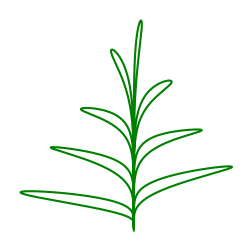

In [25]:
plt.figure(figsize=(3,3))
n = chapter_number
maxt=(2*(n-1)+3)*np.pi/2
t = np.linspace(np.pi/2, maxt, 1000)
tt= 1.0/(t+0.01)
x = (maxt-t)*np.cos(t)**3
y = t*np.sqrt(np.abs(np.cos(t))) + np.sin(0.3*t)*np.cos(2*t)
plt.plot(x, y, c="green")
plt.axis('off');

In [26]:
end = time.time()
print(f'Chapter {chapter_number} run in {int(end - start):d} seconds')

Chapter 8 run in 304 seconds
